In [24]:
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import scipy.io
import itertools
from skimage import io, filters, morphology, restoration, feature, transform
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import cycle
import sklearn.cluster
from sklearn.preprocessing import MinMaxScaler
import skimage.segmentation as seg

import numpy as np

import nglpy_cuda as ngl
import topopy
import pdir
import time
import os
import utpy.utils
import utpy.vis
import flatpy
from functools import partial
from itertools import cycle

In [25]:
light_red = "#fbb4ae"
red = "#e41a1c"

light_blue = "#b3cde3"
blue = "#377eb8"

light_green = "#ccebc5"
green = "#4daf4a"

light_purple = "#decbe4"
purple = "#984ea3"

light_orange = "#fed9a6"
orange = "#ff7f00"

yellow = "#ffff33"

white = "#ffffff"
black = "#000000"

(-0.5, 9.5, 169.5, -0.5)

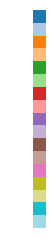

In [26]:
palettes = [[[141, 211, 199], [255, 255, 179], [190, 186, 218],
           [251, 128, 114], [128, 177, 211], [253, 180, 98],
           [179, 222, 105], [252, 205, 229], [217, 217, 217]],
          [[228,26,28], [55,126,184], [77,175,74],
           [152,78,163],[255,127,0],[255,255,51],
           [166,86,40],[247,129,191],[153,153,153]],
          [[105,239,123], [149,56,144], [66,30,200],
           [14,80,62], [153,222,249], [24,81,155],
           [218,185,255], [192,222,164], [183,211,33]],
          [[251,180,174],[179,205,227],[204,235,197],
           [222,203,228],[254,217,166],[255,255,204],
           [229,216,189],[253,218,236],[242,242,242]],
          np.array(np.array(plt.cm.tab10.colors)*255, dtype=int),
          np.array(np.array(plt.cm.tab20.colors)*255, dtype=int),
          np.array(np.array(plt.cm.tab20b.colors)*255, dtype=int),
          np.array(np.array(plt.cm.tab20c.colors)*255, dtype=int),
          [[27,158,119], [217,95,2], [117,112,179],
           [231,41,138], [102,166,30], [230,171,2],
           [166,118,29], [102,102,102]],
          [np.array(np.array(plt.cm.viridis(i/3))*255, dtype=int) for i in range(4)]
         ]

ideal_map = np.array(np.array(plt.cm.tab20.colors)*255, dtype=int)
# ideal_map = np.delete(ideal_map, 19, axis=0)
# ideal_map = np.delete(ideal_map, 17, axis=0)
ideal_map = np.delete(ideal_map, 15, axis=0)
ideal_map = np.delete(ideal_map, 14, axis=0)
ideal_map = np.delete(ideal_map, 13, axis=0)
# ideal_map = np.delete(ideal_map, 11, axis=0)
# ideal_map = np.delete(ideal_map, 9, axis=0)
# ideal_map = np.delete(ideal_map, 7, axis=0)
# ideal_map = np.delete(ideal_map, 5, axis=0)
# ideal_map = np.delete(ideal_map, 3, axis=0)
# ideal_map = np.delete(ideal_map, 1, axis=0)
palettes = [ideal_map]
color_list = ideal_map
plt.figure()
X = []
for i in range(len(color_list)):
    for row in range(10):
        x =[]
        for col in range(10):
            x.append(color_list[i])
        X.append(x)
plt.imshow(X)
plt.gca().axis("off")

In [27]:
filename = "flowDataFromBei"
mandatory_maxima = scipy.io.loadmat("data/{}/flowMandatoryMaxima.matlab".format(filename))['mandatoryMax']
n_clusters = len(np.unique(mandatory_maxima))-1
my_dir = "output/{}".format(filename)
ensemble = utpy.utils.load_ensemble(filename)

def find_closest_index(points, x):
    x = np.array(x)
    return np.argmin(np.linalg.norm(points - x, axis=1))
mandatory_maxima = scipy.io.loadmat("data/{}/flowMandatoryMaxima.matlab".format(filename))['mandatoryMax']
max_points = list()
max_counts = []
for i in range(ensemble.shape[2]):
    graph = ngl.EmptyRegionGraph(**utpy.utils.graph_params)
    tmc = topopy.MorseComplex(graph=graph,
                                gradient='steepest',
                                normalization=None)

    X, Y = utpy.utils.massage_data(ensemble[:, :, i])
    tmc.build(X, Y)
    for p in tmc.persistences:
        if len(tmc.get_partitions(p).keys()) <= n_clusters:
            for key in tmc.get_partitions(p).keys():
                max_points.append((int(X[key, 0]), int(X[key, 1])))
            break

points = []
labels = []
for row in range(mandatory_maxima.shape[0]):
    for col in range(mandatory_maxima.shape[1]):
        if mandatory_maxima[row, col] != -1:
            points.append((col, row))
            labels.append(mandatory_maxima[row, col])
points = np.array(points)

maxima_map = {}
for i in range(len(max_points)):
    maxima_map[max_points[i]] = labels[find_closest_index(points, max_points[i])]


In [28]:
mean_realization = np.mean(ensemble, axis=2)
median_realization = np.median(ensemble, axis=2)

In [12]:
persistence = utpy.utils.get_persistence_from_count(ensemble, n_clusters)
assignments = partial(utpy.utils.assign_labels, maxima_map=maxima_map, n_clusters=n_clusters, persistence=persistence)

In [13]:
def show_msc(grid, persistence=None, n_clusters=None, color="#000000", lw=2):
    X, Y = utpy.utils.massage_data(grid)
    h, w = grid.shape

    graph = ngl.EmptyRegionGraph(**utpy.utils.graph_params)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization=None)
    tmc.build(X, Y)

    if persistence is None:
        for p in tmc.persistences:
            if len(tmc.get_partitions(p).keys()) <= n_clusters:
                persistence = p
                break

    partitions = tmc.get_partitions(persistence)
    keys = partitions.keys()

    keyMap = {}
    levels = []
    for i, k in enumerate(keys):
        keyMap[k] = i
        levels.append(i+0.5)

    color_mesh = np.zeros((h, w))
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // w, idx % w] = keyMap[key]

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    for i in keyMap.values():
        lines = plt.contour(color_mesh == i, colors=color, levels=levels, linewidths=lw, linestyles="dotted")
    plt.gca().set_aspect("equal")
    return lines

In [14]:
def show_combined_overlay(ensemble, assignments, ccycle, gamma=2.2, color="#000000", lw=1, certainty=1):
        eps = 1e-6
        fig, ax = plt.subplots(4, 1, figsize=(5, 20), dpi=100)
        ps = []
        fields = []
        count = ensemble.shape[2]
        for i in range(count):
            field, p = assignments(ensemble[:, :, i])
            ps.append(p)
            fields.append(field)

        ps = np.array(ps)
        fields = np.array(fields)

        num_partitions = len(np.unique(fields))
        shape = (num_partitions,) + fields[0].shape
        label_images = np.zeros(shape)

        for i in range(num_partitions):
            test_image = (fields == i)
            label_images[i] = np.sum(test_image, axis=0)

        colored_images = []
        for i, c in zip(range(num_partitions), ccycle):
            colored_image = np.zeros(label_images[0].shape + (4,))
            colored_image[:, :, 0] = c[0]/255.
            colored_image[:, :, 1] = c[1]/255.
            colored_image[:, :, 2] = c[2]/255.
            colored_images.append(colored_image)

        certain_mask = np.zeros(label_images[0].shape, dtype=bool)
        for i, label_image in enumerate(label_images):
            colored_images[i][:, :, 3] = label_image / count
            certain_mask = np.logical_or(certain_mask, label_image / count >= certainty-eps)

        composite_image = 255*np.ones(colored_images[0].shape)[:, :, :-1]
        for colored_image in colored_images:
            composite_image = utpy.vis.overlay_alpha_image_precise(
                composite_image, 255*colored_image, 1., gamma)
        for i, triplet in zip(range(num_partitions), ccycle):
            my_color = "#{:>02}{:>02}{:>02}".format(*[hex(c).split('x')[-1] for c in triplet])
            ax[2].contourf(colored_images[i][:, :, 3], levels=[
                         certainty-eps, 1], colors="#FFFFFF", alpha=1)
            ax[3].contourf(colored_images[i][:, :, 3], levels=[
                         certainty-eps, 1], colors="#FFFFFF", alpha=1)
    #         ax[1].contourf(colored_images[i][:, :, 3], levels=[0.99999, 1], colors=my_color, alpha=1)
            ax[2].contour(colored_images[i][:, :, 3], levels=[0.5], colors="#000000", linewidths=[lw], linestyles=['solid'])
            ax[3].contour(colored_images[i][:, :, 3], levels=[0.5], colors="#000000", linewidths=[lw], linestyles=['solid'])

        certain_image = np.copy(composite_image)
        certain_image[~np.dstack((certain_mask,)*3)] = 255
        ax[0].imshow(certain_image)
        ax[1].imshow(composite_image)
        ax[2].imshow(composite_image)
        ax[3].imshow(composite_image)
        for a in ax:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
            # a.set_ylim(ensemble.shape[0], 0)
            a.set_ylim(0, ensemble.shape[0])

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


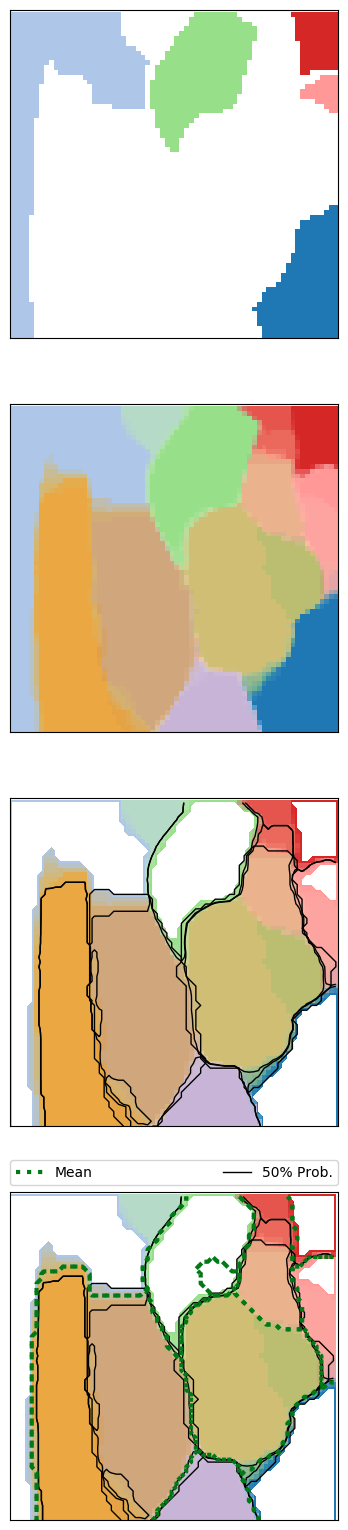

In [15]:
ideal_map = np.array(np.array(plt.cm.tab20.colors)*255, dtype=int)
ideal_map = np.delete(ideal_map, 15, axis=0)
ideal_map = np.delete(ideal_map, 14, axis=0)
ideal_map = np.delete(ideal_map, 13, axis=0)
for color_list in [ideal_map]:
    ccycle = cycle(color_list)

    umc_color = "#000000"
    gt_color = "#4daf4a"
    mean_color = "#007916"
    lw = 3
    show_combined_overlay(ensemble, assignments, ccycle, 0.2, umc_color)
    # show_msc(ground_truth, n_clusters=n_clusters, color=gt_color)
    show_msc(mean_realization, n_clusters=n_clusters, color=mean_color, lw=lw)
    # plt.plot([-1,-0.5], [0,1], color=gt_color, linewidth=1, label="Truth")
    plt.gca().plot([-1,-0.5], [0,1], color=mean_color, linewidth=lw, label="Mean", linestyle="dotted")
    plt.gca().plot([-1,-0.5], [0,1], color=umc_color, linewidth=1, label="50% Prob.")
    plt.gca().set_xlim(0, ensemble.shape[1])
    plt.gca().set_ylim(0,ensemble.shape[0])
    _ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)


(-0.5, 9.5, 169.5, -0.5)

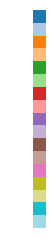

In [16]:
color_list = ideal_map
plt.figure()
X = []
for i in range(len(color_list)):
    for row in range(10):
        x =[]
        for col in range(10):
            x.append(color_list[i])
        X.append(x)
plt.imshow(X)
plt.gca().axis("off")

In [17]:
def show_certain_regions(ensemble, assignments, contours=False):
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count

    for i, color in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(
            *[hex(c).split('x')[-1] for c in color])
        plt.contourf(colored_images[i][:, :, 3], levels=[
                     0.99999, 1], colors=my_color, alpha=1)
        if contours:
            plt.contour(colored_images[i][:, :, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[
                        1, 0.5, 1.0], linestyles=['solid', 'dashed', 'solid'])
        # else:
        #     plt.contour(colored_images[i][:, :, 3], levels=[0.0, 1], colors=my_color, linewidths=[
        #                 1, 1.0], linestyles=['solid', 'dashed', 'solid'])
    plt.gca().set_xlim(0, ensemble.shape[1])
    # plt.gca().set_ylim(ensemble.shape[0], 0)
    plt.gca().set_ylim(0, ensemble.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_aspect('equal')

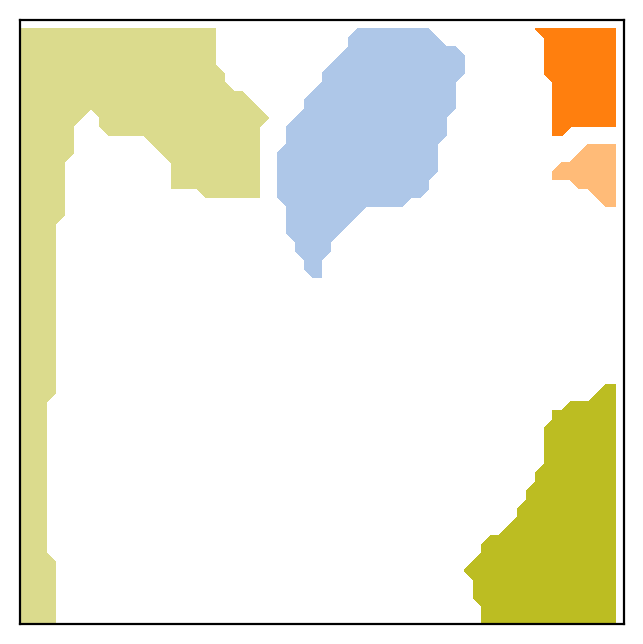

In [18]:
plt.figure(dpi=200)
show_certain_regions(ensemble, assignments)

<IPython.core.display.Javascript object>


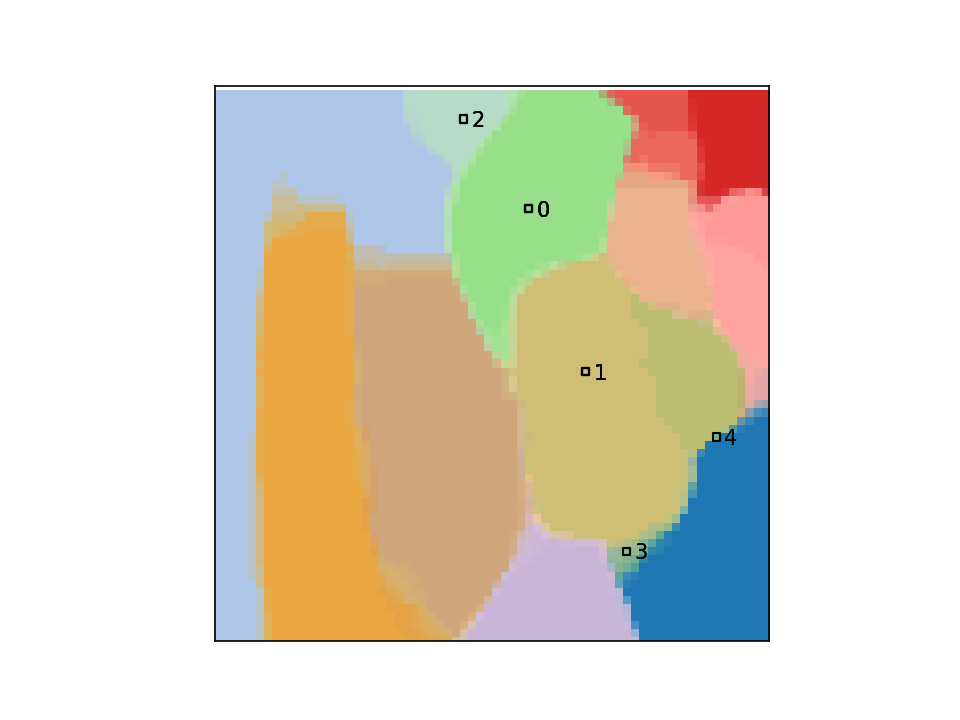

In [22]:
%matplotlib notebook

selected_points = []

plt.ion()
fig = plt.figure(num=None, dpi=150)
ccycle = cycle(color_list)

gamma = 0.2
certainty = 1
eps = 1e-6
ps = []
fields = []
count = ensemble.shape[2]
for i in range(count):
    field, p = assignments(ensemble[:, :, i])
    ps.append(p)
    fields.append(field)

ps = np.array(ps)
fields = np.array(fields)

num_partitions = len(np.unique(fields))
shape = (num_partitions,) + fields[0].shape
label_images = np.zeros(shape)

for i in range(num_partitions):
    test_image = (fields == i)
    label_images[i] = np.sum(test_image, axis=0)

colored_images = []
for i, c in zip(range(num_partitions), ccycle):
    colored_image = np.zeros(label_images[0].shape + (4,))
    colored_image[:, :, 0] = c[0]/255.
    colored_image[:, :, 1] = c[1]/255.
    colored_image[:, :, 2] = c[2]/255.
    colored_images.append(colored_image)

certain_mask = np.zeros(label_images[0].shape, dtype=bool)
for i, label_image in enumerate(label_images):
    colored_images[i][:, :, 3] = label_image / count
    certain_mask = np.logical_or(certain_mask, label_image / count >= certainty-eps)

composite_image = 255*np.ones(colored_images[0].shape)[:, :, :-1]
for colored_image in colored_images:
    composite_image = utpy.vis.overlay_alpha_image_precise(
        composite_image, 255*colored_image, 1., gamma)
plt.imshow(composite_image)
a = plt.gca()
a.get_xaxis().set_visible(False)
a.get_yaxis().set_visible(False)
# a.set_ylim(ensemble.shape[0], 0)
a.set_ylim(0, ensemble.shape[0])


def onclick(event):
    row = int(event.ydata+0.5)
    col = int(event.xdata+0.5)    
    selected_points.append((col, row))
    bg_points = np.array(selected_points)
    plt.scatter(bg_points[:, 0], bg_points[:, 1], edgecolor=black, facecolor='none', s=12, marker=',', zorder=4)
    for i in range(len(selected_points)):
        plt.text(selected_points[i][0]+1, selected_points[i][1]-1, i)
    fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

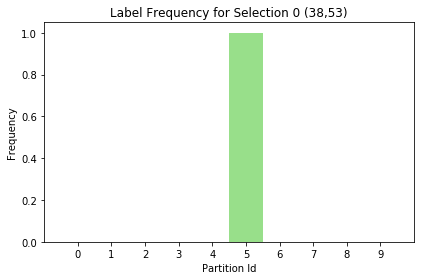

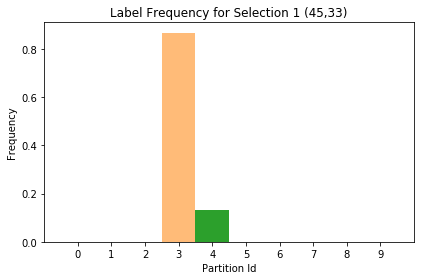

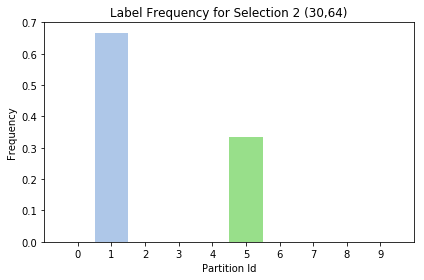

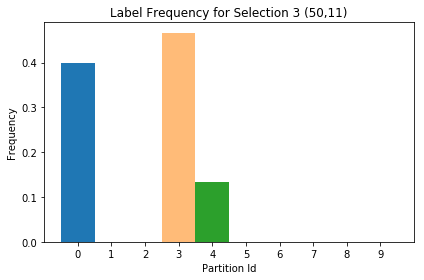

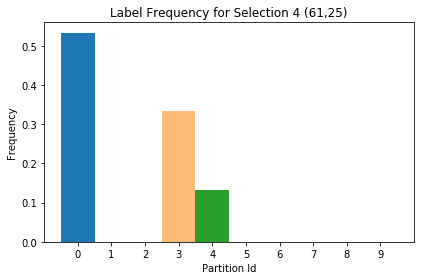

In [23]:
%matplotlib inline

selected = np.array(selected_points)

for i, row in enumerate(selected):
    n_groups = label_images.shape[0]
    colors = np.array([ tuple(c) + (255,) for c in color_list])

    label_counts = label_images[:, row[1], row[0]] / 15


    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 1.

    opacity = 1.

    rects1 = ax.bar(index, label_counts, bar_width,
                    alpha=opacity, color=colors / 255.)

    ax.set_xlabel('Partition Id')
    ax.set_ylabel('Frequency')
    ax.set_title('Label Frequency for Selection {} ({},{})'.format(i, row[0], row[1]))
    ax.set_xticks(index)
    ax.set_xticklabels([str(i) for i in range(15)])
    fig.tight_layout()
    plt.show()
